#### Importing Libraries 

In [73]:
import os
import cv2
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout


In [74]:
labels = [label for label in os.listdir("./train") if not label.startswith('.')]
labels

['Closed', 'no_yawn', 'yawn', 'Open']

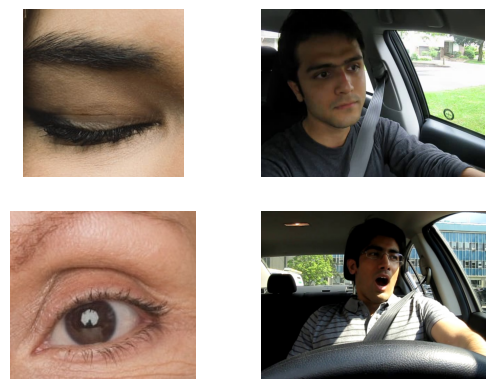

In [75]:
# Define the paths to your image directories
class_paths = ["./train/Closed/", "./train/no_yawn/", "./train/Open/", "./train/yawn/"]

# Create a list to hold images
images = []

# Read images from each class directory
for path in class_paths:
    image_files = os.listdir(path)
    # Read the first image from each class
    if image_files:
        image = plt.imread(os.path.join(path, image_files[0]))
        images.append(image)

# Create a 2x2 grid
fig, axs = plt.subplots(2, 2)

# Display images in the grid
for i in range(2):
    for j in range(2):
        if i * 2 + j < len(images):
            axs[i, j].imshow(images[i * 2 + j])
            axs[i, j].axis('off')  # Turn off axis labels

# Show the grid of images
plt.show()


In [76]:
a = plt.imread("./train/yawn/10.jpg")
a.shape

(480, 640, 3)

In [77]:
def face_for_yawn(direc="./train", face_cas_path="./test/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [78]:
def get_data(dir_path, face_cas, eye_cas):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

data_train=get_data("./train/","./test/haarcascade_frontalface_default.xml", "./test/haarcascade.xml")


2
3


In [79]:


def append_data():
    dir_path = "./train/"  
    face_cas = "./test/haarcascade_frontalface_default.xml" 
    eye_cas = "./test/haarcascade.xml"  
    
    yaw_no = face_for_yawn()
    data = get_data(dir_path, face_cas, eye_cas)  # Provide the required arguments
    
    yaw_no.extend(data)
    return yaw_no  # Remove np.array conversion here

new_data = append_data()

X = []
y = []

# Assuming new_data is a list of tuples (feature, label)
for feature, label in new_data:
    X.append(feature)
    y.append(label)

X = np.array(X)  # Convert X to a NumPy array
y = np.array(y)  # Convert y to a NumPy array


0
1
2
3


In [80]:
# Reshape X and binarize labels
X = X.reshape(-1, 145, 145, 3)
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

#### Model Training

In [81]:

seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)


In [82]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [83]:

model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [84]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [85]:
history = model.fit(train_generator, epochs=100, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/100


2023-09-26 22:45:51.637461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.3972

2023-09-26 22:46:03.075594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 14s 290ms/step - loss: 1.3172 - accuracy: 0.3972 - val_loss: 1.2504 - val_accuracy: 0.5830
Epoch 2/100
43/43 [==============================] - 9s 207ms/step - loss: 1.1132 - accuracy: 0.5739 - val_loss: 0.9690 - val_accuracy: 0.5882
Epoch 3/100
43/43 [==============================] - 9s 202ms/step - loss: 0.6660 - accuracy: 0.7424 - val_loss: 0.5864 - val_accuracy: 0.7422
Epoch 4/100
43/43 [==============================] - 9s 204ms/step - loss: 0.4565 - accuracy: 0.8255 - val_loss: 0.4619 - val_accuracy: 0.8322
Epoch 5/100
43/43 [==============================] - 9s 201ms/step - loss: 0.3546 - accuracy: 0.8582 - val_loss: 0.3980 - val_accuracy: 0.8426
Epoch 6/100
43/43 [==============================] - 9s 198ms/step - loss: 0.3329 - accuracy: 0.8641 - val_loss: 0.3292 - val_accuracy: 0.8772
Epoch 7/100
43/43 [==============================] - 9s 197ms/step - loss: 0.2836 - accuracy: 0.8909 - val_loss: 0.2967 - val_accuracy: 0.8979
Epoch 8/10

#### Evaluation

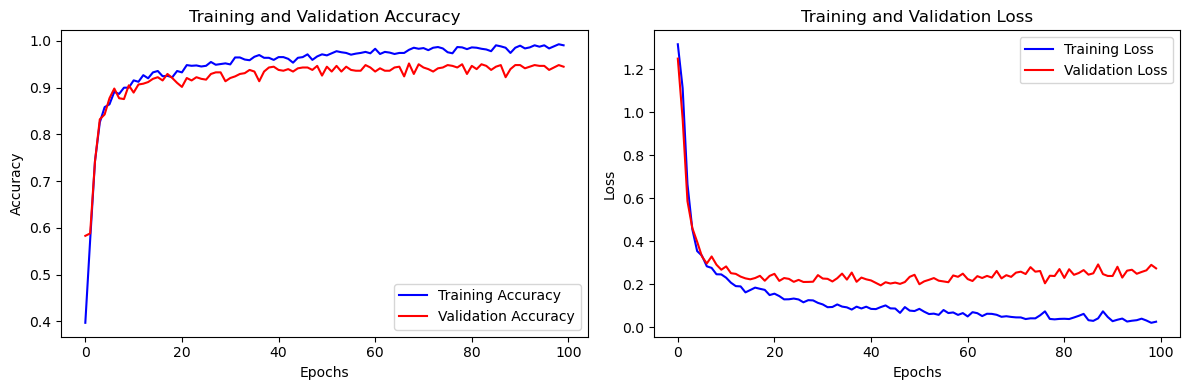

In [86]:
# Get training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


2023-09-26 23:00:14.654271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 66ms/step


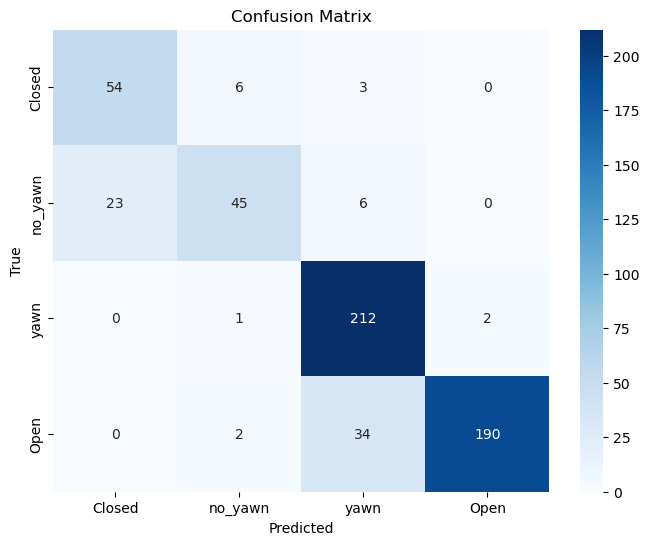

              precision    recall  f1-score   support

      Closed       0.70      0.86      0.77        63
     no_yawn       0.83      0.61      0.70        74
        yawn       0.83      0.99      0.90       215
        Open       0.99      0.84      0.91       226

    accuracy                           0.87       578
   macro avg       0.84      0.82      0.82       578
weighted avg       0.88      0.87      0.87       578



In [87]:
# Perform predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))


In [88]:
def prepare(filepath, face_cas="./test/haarcascade_frontalface_default.xml"):
    IMG_SIZE = 145  # Define the image size
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [89]:
prediction = model.predict([prepare("./train/yawn/1.jpg")])
predicted_class = np.argmax(prediction)
print(f"Predicted class: {labels[predicted_class]}")


2023-09-26 23:00:16.373145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 364ms/step
Predicted class: yawn


#### Saving the Model

In [90]:
model.save("drowsy.h5")

In [91]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("drowsy.json", "w") as json_file:
    json_file.write(model_json)
